# Problem Set 1: Analysis of racial disparities in felony sentencing

# 0. Load packages and imports

In [1]:
## basic functionality
import pandas as pd
import numpy as np
import re

## can add others if you need them
import matplotlib.pyplot as plt
from plotnine import *
from datetime import datetime

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 0.1: Load the data (0 points)

Load the `sentencing_asof0405.csv` data

*Notes*: You may receive a warning about mixed data types upon import; feel free to ignore

In [2]:
S = sentencing = pd.read_csv("pset1_inputdata/sentencing_asof0405.csv", low_memory = False)

## 0.2: Print head, dimensions, info (0 points)

In [3]:
S.head
S.shape
S.info

<bound method NDFrame.head of              CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0       149765331439         175691153649  8/15/1984 12:00:00 AM   
1       149765331439         175691153649  8/15/1984 12:00:00 AM   
2       149765331439         175691153649  8/15/1984 12:00:00 AM   
3       149765331439         175691153649  8/15/1984 12:00:00 AM   
4       149765331439         175691153649  8/15/1984 12:00:00 AM   
...              ...                  ...                    ...   
248141  445516248775         905289187184   2/3/2021 12:00:00 AM   
248142  445527409730         905322500577   2/4/2021 12:00:00 AM   
248143  445587767000         905518794790   2/9/2021 12:00:00 AM   
248144  445592613204         905533705601   2/9/2021 12:00:00 AM   
248145  445593200623         905535215556   2/9/2021 12:00:00 AM   

                                 OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG  \
0                               PROMIS Conversion                False   
1    

(248146, 41)

<bound method DataFrame.info of              CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0       149765331439         175691153649  8/15/1984 12:00:00 AM   
1       149765331439         175691153649  8/15/1984 12:00:00 AM   
2       149765331439         175691153649  8/15/1984 12:00:00 AM   
3       149765331439         175691153649  8/15/1984 12:00:00 AM   
4       149765331439         175691153649  8/15/1984 12:00:00 AM   
...              ...                  ...                    ...   
248141  445516248775         905289187184   2/3/2021 12:00:00 AM   
248142  445527409730         905322500577   2/4/2021 12:00:00 AM   
248143  445587767000         905518794790   2/9/2021 12:00:00 AM   
248144  445592613204         905533705601   2/9/2021 12:00:00 AM   
248145  445593200623         905535215556   2/9/2021 12:00:00 AM   

                                 OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG  \
0                               PROMIS Conversion                False   
1  

# Part one: data cleaning/interpretation

## 1.1: Understanding the unit of analysis (5 points)

- Print the number of unique values for the following columns. Do so in a way that avoids copying/pasting code for 
the three:

    - Cases (`CASE_ID`)
    - People in that case (`CASE_PARTICIPANT_ID`)
    - Charges (`CHARGE_ID`)

- Write a couple sentences on the following and show an example of each (e.g., a case involving multiple people):
    
    - Why there are more unique people than unique cases?
    - Why there are more unique charges than unique people?

- Print the mean and median number of charges per case/participant 

- Print the mean and median number of participants per case

- Does the data seem to enable us to follow the same defendant across different cases they're charged in? Write 1 sentence in support of your conclusion.


In [4]:
def unique_val(column):
    return S[column].nunique()

cols = ["CASE_ID", "CASE_PARTICIPANT_ID", "CHARGE_ID"]

for i in cols:
    print(unique_val(i))

197519
211977
229015


There are more unique people than unique cases because certain cases involve multiple perpetrators. For example, the next line shows the cases with the most unique participants.

In [5]:
S.groupby("CASE_ID")["CASE_PARTICIPANT_ID"].nunique().sort_values(ascending = False).reset_index().head()

,CASE_ID,CASE_PARTICIPANT_ID
0,388821827872,17
1,400683867135,17
2,421499635741,13
3,410451024505,13
4,387258266181,10


There are more unique charges than unique people because many people are charged with multiple crimes in their case(s). For example, the next line shows the participants that accrued the most charges.

In [6]:
S.groupby(["CASE_ID","CASE_PARTICIPANT_ID"])["CHARGE_ID"].count().sort_values(ascending = False).reset_index().head()

,CASE_ID,CASE_PARTICIPANT_ID,CHARGE_ID
0,181880245351,179640159105,99
1,210642026541,202888754974,81
2,213788534740,204215911473,74
3,401360132899,764908059450,59
4,228477967001,213339345634,54


In [7]:
# In this case there are both more than one participant and more than one charge per participant.
case_ex = S.groupby(["CASE_ID","CASE_PARTICIPANT_ID"])["CHARGE_ID"].count().sort_values(ascending = False).reset_index().head(1).get("CASE_ID")
S[S["CASE_ID"] == case_ex[0]]

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,INCIDENT_CITY,INCIDENT_BEGIN_DATE,INCIDENT_END_DATE,LAW_ENFORCEMENT_AGENCY,LAW_ENFORCEMENT_UNIT,ARREST_DATE,FELONY_REVIEW_DATE,FELONY_REVIEW_RESULT,ARRAIGNMENT_DATE,UPDATED_OFFENSE_CATEGORY
266,181880245351,179640159105,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69240855975,346314890356,MURDER/OTHER FORCIBLE FELONY,2,4/16/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,7/20/2004 10:00:00 PM,08/24/2004 12:00:00 AM,Charge(S) Approved,9/9/2004 12:00:00 AM,PROMIS Conversion
267,181880245351,179640159105,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69240906251,346314329833,MURDER/OTHER FORCIBLE FELONY,3,4/16/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,7/20/2004 10:00:00 PM,08/24/2004 12:00:00 AM,Charge(S) Approved,9/9/2004 12:00:00 AM,PROMIS Conversion
268,181880245351,179640159105,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69240956527,346312741683,MURDER/OTHER FORCIBLE FELONY,4,4/16/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,7/20/2004 10:00:00 PM,08/24/2004 12:00:00 AM,Charge(S) Approved,9/9/2004 12:00:00 AM,PROMIS Conversion
269,181880245351,179640159105,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69241006802,346312835104,MURDER/OTHER FORCIBLE FELONY,5,4/16/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,7/20/2004 10:00:00 PM,08/24/2004 12:00:00 AM,Charge(S) Approved,9/9/2004 12:00:00 AM,PROMIS Conversion
270,181880245351,179640159105,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69241057078,346312928524,MURDER/OTHER FORCIBLE FELONY,6,4/16/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,7/20/2004 10:00:00 PM,08/24/2004 12:00:00 AM,Charge(S) Approved,9/9/2004 12:00:00 AM,PROMIS Conversion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,181880245351,180263204488,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69450455690,276034039183,MURDER/STRONG PROB KILL/INJURE,29,4/5/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,8/24/2004 5:30:00 AM,08/24/2004 12:00:00 AM,Charge(S) Approved,NaN,PROMIS Conversion
386,181880245351,180263204488,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69450505966,276034132603,MURDER/STRONG PROB KILL/INJURE,31,4/5/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,8/24/2004 5:30:00 AM,08/24/2004 12:00:00 AM,Charge(S) Approved,NaN,PROMIS Conversion
387,181880245351,180263204488,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69450556241,276033291818,MURDER/STRONG PROB KILL/INJURE,33,4/5/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,8/24/2004 5:30:00 AM,08/24/2004 12:00:00 AM,Charge(S) Approved,NaN,PROMIS Conversion
388,181880245351,180263204488,8/24/2004 12:00:00 AM,PROMIS Conversion,False,69465840078,346317879814,MURDER/OTHER FORCIBLE FELONY,23,4/5/2012 12:00:00 AM,...,NaN,7/6/2004 12:00:00 AM,7/7/2004 12:00:00 AM,ROBBINS POLICE DEPARTMENT,NaN,8/24/2004 5:30:00 AM,08/24/2004 12:00:00 AM,Charge(S) Approved,NaN,PROMIS Conversion


In [8]:
def div_cases(x, per_x, func):
    return func(S.groupby(per_x)[x].nunique())


mean_charges_case = div_cases("CHARGE_ID", "CASE_ID", np.mean)
print(mean_charges_case)

mean_charges_participant = div_cases("CHARGE_ID", "CASE_PARTICIPANT_ID", np.mean)
print(mean_charges_participant)

mean_participants_case = div_cases("CASE_PARTICIPANT_ID", "CASE_ID", np.mean)
print(mean_participants_case)

med_charges_case = div_cases("CHARGE_ID", "CASE_ID", np.median)
print(med_charges_case)

med_charges_participant = div_cases("CHARGE_ID", "CASE_PARTICIPANT_ID", np.median)
print(med_charges_participant)

med_participants_case = div_cases("CASE_PARTICIPANT_ID", "CASE_ID", np.median)
print(med_participants_case)

1.1594580774507768
1.1261457610967227
1.0731980214561636
1.0
1.0
1.0


The following code shows that there are no participant IDs that appear in multiple cases, so it is not possible to follow the same defendant across different cases they're charged in.

In [9]:
follow_defend = S[["CASE_PARTICIPANT_ID", "CASE_ID"]].drop_duplicates()
follow_defend.groupby("CASE_PARTICIPANT_ID")["CASE_ID"].count().sort_values(ascending = False).reset_index().head()

,CASE_PARTICIPANT_ID,CASE_ID
0,96757475659,1
1,811339945611,1
2,811332962067,1
3,811333245184,1
4,811333433928,1


# 1.2.1: Which offense is final? (3 points)

- First, read the data documentation [link](https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf) and summarize in your own words the differences between `OFFENSE_CATEGORY` and `UPDATED_OFFENSE_CATEGORY` 

- Construct an indicator `is_changed_offense` that's True for case-participant-charge observations (rows) where there's a difference between the original charge (offense category) and the most current charge (updated offense category). What are some of the more common changed offenses? (can just print result of sort_values based on original offense category)

- Print one example of a changed offense from one of these categories and comment on what the reason may be


The offense category is the category of charges brought against the defendent in the case as noted on intake before more specific charges are officially filed. The updated offense category is the final version of the category for the charge being filed. They are sometimes different because cases tend to change over time and new details are uncovered.

In [10]:
S["is_changed_offense"] = (S["OFFENSE_CATEGORY"] != S["UPDATED_OFFENSE_CATEGORY"])

S[S["is_changed_offense"]]["OFFENSE_CATEGORY"].reset_index().groupby("OFFENSE_CATEGORY").count().sort_values(by="index", ascending = False).head()

S[(S["OFFENSE_CATEGORY"] == "DUI") & (S["is_changed_offense"])].iloc[0]

,index
OFFENSE_CATEGORY,
PROMIS Conversion,6394
DUI,3896
UUW - Unlawful Use of Weapon,2155
Other Offense,2125
Aggravated Battery,1927


CASE_ID                                                                   377427814448
CASE_PARTICIPANT_ID                                                       695176993911
RECEIVED_DATE                                                    4/22/2010 12:00:00 AM
OFFENSE_CATEGORY                                                                   DUI
PRIMARY_CHARGE_FLAG                                                               True
CHARGE_ID                                                                 335034309383
CHARGE_VERSION_ID                                                         622701031647
DISPOSITION_CHARGED_OFFENSE_TITLE    AGGRAVATED DRIVING UNDER THE INFLUENCE OF ALCOHOL
CHARGE_COUNT                                                                         1
DISPOSITION_DATE                                                  2/1/2011 12:00:00 AM
DISPOSITION_CHARGED_CHAPTER                                                        625
DISPOSITION_CHARGED_ACT                    

The most common changed offenses include PROMIS conversion (which has something to do with prosecution software), DUI, and UUW. The changed offense I printed shows a change from DUI to Aggravated DUI. "DUI" is probably what was entered as a generic placeholder upon intake, and then the facts were later clarified and it was updated to Aggravated DUI.

## 1.2.2: Simplifying the charges (5 points)

Using the field (`UPDATED_OFFENSE_CATEGORY`), create a new field, `simplified_offense_derived`, that simplifies the many offense categories into broader buckets using the following process:

First, combine all offenses beginning with "Aggravated" into a single category without that prefix (e.g., Aggravated Battery and Battery just becomes Battery)

Then:
- Combine all offenses with arson into a single arson category (`Arson`)
- Combine all offenses with homicide into a single homicide category (`Homicide`)
- Combine all offenses with vehicle/vehicular in the name into a single vehicle category (`Vehicle-related`)
- Combine all offenses with battery in the name into a single battery category (`Battery`)

Try to do so efficiently (e.g., using map and a dictionary or np.select rather than separate line for each recoded offense)

Print the difference between the # of unique offenses in the original `UPDATED_OFFENSE_CATEGORY` field and the # of unique offenses in your new `simplified_offense_derived` field


In [11]:
aggravated = S["UPDATED_OFFENSE_CATEGORY"].str.contains("Aggravated")
S["simplified_offense_derived"] = np.where(aggravated, 
                                           S["UPDATED_OFFENSE_CATEGORY"].str[11:], 
                                           S["UPDATED_OFFENSE_CATEGORY"])

comb_list = [S["UPDATED_OFFENSE_CATEGORY"].str.contains("Arson"), 
             S["UPDATED_OFFENSE_CATEGORY"].str.contains("Homicide"),
            S["UPDATED_OFFENSE_CATEGORY"].str.contains("Vehicle"),
             S["UPDATED_OFFENSE_CATEGORY"].str.contains("Vehicular"),
            S["UPDATED_OFFENSE_CATEGORY"].str.contains("Battery")]
res_list = ["Arson", "Homicide", "Vehicle-related", "Vehicle-related", "Battery"]
S["simplified_offense_derived"] = np.select(comb_list, res_list, S["simplified_offense_derived"])


print(unique_val("UPDATED_OFFENSE_CATEGORY"))
print(unique_val("simplified_offense_derived"))
print(unique_val("UPDATED_OFFENSE_CATEGORY") - unique_val("simplified_offense_derived"))

79
65
14


## 1.3: Cleaning additional variables (10 points)

Clean the following variables; make sure to retain the original variable in data and use the derived suffix so it's easier to pull these cleaned out variables later (e.g., `age_derived`) to indicate this was a transformation

- Race: create True/false indicators for `is_black_derived` (Black only or mixed race with hispanic), Non-Black Hispanic, so either hispanic alone or white hispanic (`is_hisp_derived`), White non-hispanic (`is_white_derived`), or none of the above (`is_othereth_derived`)

- Gender: create a boolean true/false indicator for `is_male_derived` (false is female, unknown, or other)

- Age at incident: you notice outliers like 130-year olds. Winsorsize the top 0.01% of values to be equal to the 99.99th percentile value pre-winsorization. Call this `age_derived`

- Create `sentenceymd_derived` that's a version of `SENTENCING_DATE` converted to datetime format. Also create a rounded version, `sentenceym_derived`, that's rounded down to the first of the month and the year (e.g., 01-05-2016 and 01-27-2016 each become 01-01-2016)
    - Hint: all timestamps are midnight so u can strip in conversion. For full credit, before converting, you notice that some of the years have been mistranscribed (e.g., 291X or 221X instead of 201X). Programatically fix those (eg 2914 -> 2014). Even after cleaning, there will still be some that are after the year 2021 that we'll filter out later. For partial credit, you can ignore the timestamps that cause errors and set errors = "coerce" within `pd.to_datetime()` to allow the conversion to proceed. 

- Sentencing judge: create an identifier (`judgeid_derived`) for each unique judge (`SENTENCE_JUDGE`) structured as judge_1, judge_2...., with the order determined by sorting the judges (will sort on fname then last). When finding unique judges, there are various duplicates we could weed out --- for now, just focus on (1) the different iterations of Doug/Douglas Simpson, (2) the different iterations of Shelley Sutker (who appears both with her maiden name and her hyphenated married name). 
     - Hint: due to mixed types, you may need to cast the `SENTENCE_JUDGE` var to a diff type to sort

After finishing, print a random sample of 10 rows (data.sample(n = 10)) with the original and cleaned columns for the relevant variables to validate your work

In [12]:
#Race
S["is_black_derived"] = S["RACE"].str.contains("Black")
S["is_hisp_derived"] = (S["RACE"] == "HISPANIC") | (S["RACE"] == "White [Hispanic or Latino]")
S["is_white_derived"] = S["RACE"] == "White"
S["is_othereth_derived"] = ~((S["is_black_derived"]) | (S["is_hisp_derived"]) | (S["is_white_derived"]))

#Gender
S["is_male_derived"] = S["GENDER"] == "Male"

#Age
threshold = S["AGE_AT_INCIDENT"].quantile(0.9999)
S["age_derived"] = np.clip(S["AGE_AT_INCIDENT"], a_min = 0, a_max = threshold)

#Date
S["SENTENCE_DATE"] = S["SENTENCE_DATE"].replace("291|221", "201", regex = True)
S["sentenceymd_derived"] = pd.to_datetime(S["SENTENCE_DATE"])
S[["SENTENCE_DATE", "sentenceymd_derived"]]

#Judges
judges = S["SENTENCE_JUDGE"].sort_values().unique().tolist()
judges.remove("Douglas J Simpson")
judges.remove("Shelley  Sutker-Dermer")
judges_dict = {judge : f"judge_{i + 1}" for i, judge in enumerate(judges)}

judges_dict["Douglas J Simpson"] = judges_dict.get("Doug  Simpson")
judges_dict["Shelley  Sutker-Dermer"] = judges_dict.get("Shelley  Sutker")

S["judgeid_derived"] = S["SENTENCE_JUDGE"].map(judges_dict)

S[["SENTENCE_JUDGE", "judgeid_derived"]].sample(n = 10)

,SENTENCE_DATE,sentenceymd_derived
0,6/2/1986 12:00:00 AM,1986-06-02
1,6/2/1986 12:00:00 AM,1986-06-02
2,6/2/1986 12:00:00 AM,1986-06-02
3,6/2/1986 12:00:00 AM,1986-06-02
4,10/16/2014 12:00:00 AM,2014-10-16
...,...,...
248141,3/19/2021 12:00:00 AM,2021-03-19
248142,3/23/2021 12:00:00 AM,2021-03-23
248143,3/11/2021 12:00:00 AM,2021-03-11
248144,3/11/2021 12:00:00 AM,2021-03-11


,SENTENCE_JUDGE,judgeid_derived
83227,ELLEN MANDELTORT,judge_72
51184,Joseph Michael Claps,judge_155
112939,Clayton Jay Crane,judge_41
184174,Arthur F Hill,judge_18
189654,Joan Margaret O'Brien,judge_134
102436,Larry G Axelrood,judge_175
115340,Vincent M Gaughan,judge_321
216494,Nicholas R Ford,judge_236
92521,Nicholas R Ford,judge_236
197602,Erica L Reddick,judge_82


## 1.4: Subsetting rows to analytic dataset (5 points)

You decide based on the above to simplify things in the following ways:
    
- Subset to cases where only one participant is charged, since cases with >1 participant might have complications like 
plea bargains/informing from other participants affecting the sentencing of the focal participant

- To go from a participant-case level dataset, where each participant is repeated across charges tied to the case, to a participant-level dataset, where each participant has one charge, subset to a participant's primary charge and their current sentence (`PRIMARY_CHARGE_FLAG` is True and `CURRENT_SENTENCE_FLAG` is True). Double check that this worked by confirming there are no longer multiple charges for the same case-participant

- Filter out observations where judge is nan or nonsensical (indicated by is.null or equal to FLOOD)

- Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)

After completing these steps, print the number of rows in the data

In [13]:
#subset for only one participant
#temp dataframe
case_df = S.groupby("CASE_ID")["CASE_PARTICIPANT_ID"].nunique().reset_index()
case_list = case_df[case_df["CASE_PARTICIPANT_ID"] == 1]["CASE_ID"].tolist()

#final sub-dataframe
sub_S = S[S["CASE_ID"].isin(case_list) 
          & S["PRIMARY_CHARGE_FLAG"] 
          & S["CURRENT_SENTENCE_FLAG"]
          & S["SENTENCE_JUDGE"].notnull() 
          & (S["sentenceymd_derived"] >= pd.to_datetime("2012-01-01")) 
          & (S["sentenceymd_derived"] <= pd.to_datetime("2021-04-05"))]

#verifying
sub_S.groupby(["CASE_ID", "CASE_PARTICIPANT_ID"])["CHARGE_ID"].nunique().sort_values(ascending = False).reset_index().head()

#number of rows
len(sub_S.index)

,CASE_ID,CASE_PARTICIPANT_ID,CHARGE_ID
0,149765331439,175691153649,1
1,418301728407,818076234522,1
2,418300553570,818071421539,1
3,418300259860,818070666561,1
4,418299966151,818070005955,1


135162

# Part two: investigating Black vs. White sentencing disparities

Now that the data are cleaned, we're going to investigate different types of disparities in sentencing between Black defendants and White defendants. We're focusing on these groups for the purpose of the problem set, but the analysis could be extended to study Hispanic defendants or, in a different jurisdiction, Asian and other minoritized groups.

**Details if interested in digging deeper**: If interested (optional), you can read more technical coverage of how we might (1) measure disparities, and (2) what factors you want to adjust for when deciding whether two defendants are 'similarly situated' but for their race in the following sources:

- [Review of sentencing disparities research](https://www.journals.uchicago.edu/doi/full/10.1086/701505)
- [Discussion of causal model/blinding race at charging stage of the prosecutorial process](https://5harad.com/papers/blind-charging.pdf)
- [Discussion of measuring discrimination in policing that can generalize to the sentencing case](https://www.annualreviews.org/doi/abs/10.1146/annurev-criminol-011518-024731)
- [General discussion of causal challenges in measuring between-group disparities](https://osf.io/preprints/socarxiv/gx4y3/)

**One major caveat**: when investigating whether two similar defendants received different sentences, we're missing one important attribute that influences sentencing: the defendant's criminal history. This influences sentencing both through sentencing guidelines, which can prescribe longer sentences for those who have certain types of prior convictions, and through judicial discretion if judges are more lenient with first-time defendants. The above sources discuss how much we want to "control away" for this prior history, since if we think there are racial biases in which defendants, conditional on *committing* a crime, are arrested and charged, we may not want to adjust for that factor. More discussion [in this article](https://www.themarshallproject.org/2019/12/03/the-growing-racial-disparity-in-prison-time)


## 2.0: (0 points)

First, read in the following dataset (regardless of progress on part one): `sentencing_cleaned.pkl` (if you can't read in the pkl you can read in the .csv format but may need to recast some of the datetime columns)

*Note*: don't worry if there are slight differences in your output from Part One and this dataset/it's not a good use of time to try to reverse engineer Part One answers from this cleaned data.

In [14]:
C = sentencing_cleaned = pd.read_csv("pset1_inputdata/sentencing_cleaned.csv", low_memory = False)

## 2.1: Investigating one type of between-group difference: who reaches the sentencing stage? (5 points)

Tabulate and visualize the proportion of defendants, out of all defendants sentenced in a given month/year, who are Black and who are White (separate proportions)

- Denominator is number of unique cases that month
- Numerator for black defendants is count of is_black_derived
- Numerator for white defendants is count of is_white_derived
- Fraction of each is numerator/denominator

- Print the table
- Create a graph with two lines--- one for Black defendants as fraction of total; another for White defendants. Make sure it includes a legend summarizing which color is for which group, and clean the legend so that it has informative names (e.g., Black or White rather than prop_black or prop_white)
- Use mathematical notation to write out each of the proportions using summation notation in a 1-2 sentence writeup describing trends. What seems to be going on in April and May 2020? 

**Optional challenge**: improve the viz by shading the background of the visualization for months with fewer than 100 cases 

**Optional challenge**: improve the viz by adding a vertical line for 12-01-2016, the month that new State's Attorney Foxx took office 

,sentenceym_derived,prop_Black,prop_White
0,2012-01-01,0.677419,0.144564
1,2012-02-01,0.648966,0.160690
2,2012-03-01,0.638958,0.158189
3,2012-04-01,0.696379,0.146936
4,2012-05-01,0.695146,0.144337
...,...,...,...
106,2020-11-01,0.606925,0.154786
107,2020-12-01,0.646182,0.158287
108,2021-01-01,0.621924,0.111857
109,2021-02-01,0.651731,0.134420


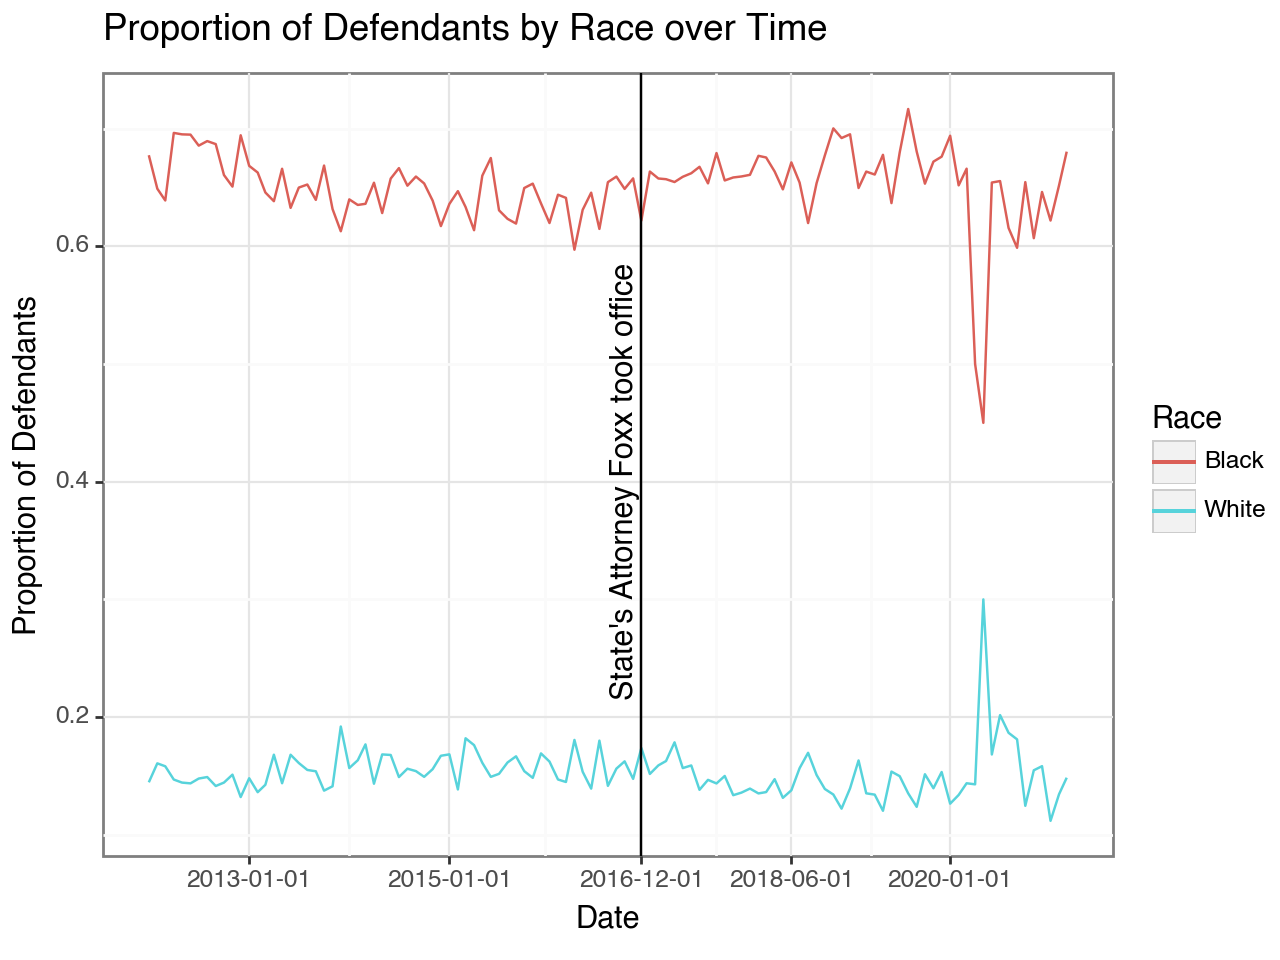

<Figure Size: (640 x 480)>

In [15]:
# find numbers by month
cases_month = C.groupby("sentenceym_derived")["CASE_ID"].agg("count")
black_def_month = C[C["is_black_derived"]].groupby("sentenceym_derived")["CASE_ID"].agg("count")
white_def_month = C[C["is_white_derived"]].groupby("sentenceym_derived")["CASE_ID"].agg("count")

#calculate proportions
frac_black = black_def_month / cases_month
frac_white = white_def_month / cases_month

#merge data
bw_def = pd.merge(frac_black, frac_white, on = "sentenceym_derived").reset_index()
bw_def = bw_def.rename(columns = {"CASE_ID_x":"prop_Black", "CASE_ID_y":"prop_White"})
bw_def
bw_def = pd.wide_to_long(bw_def, stubnames = "prop", i = "sentenceym_derived", j = "Race", sep='_', suffix=r'\w+')
bw_def = bw_def.reset_index()

#visualize
(ggplot(data = bw_def) +
 geom_line(aes(x = "sentenceym_derived", y = "prop", color = "Race", group = "Race")) +
 ggtitle("Proportion of Defendants by Race over Time") +
 labs(x = "Date", y = "Proportion of Defendants") +
 scale_x_date(breaks = ("2013-01-01", "2015-01-01", "2016-12-01", "2018-06-01", "2020-01-01")) +
 geom_vline(xintercept = pd.to_datetime("2016-12-01")) +
 annotate(geom = "text", label = "State's Attorney Foxx took office", x = "2016-10-01", y = 0.4, angle = 90) +
 theme_bw())
 

The proportion of sentenced defendants who are black is equal to: $$P_{\text{Black}} = \frac{\sum \text{is_black_derived}}{\sum \text{CASE_ID}}$$ while the proportion of sentenced defendants who are white is equal to: $$P_{\text{White}} = \frac{\sum \text{is_white_derived}}{\sum \text{CASE_ID}}$$
April and May 2020 was the first wave of COVID-19 lockdowns, and thus there was very little sentencing taking place. We see changes in the data because the sample size was much smaller.

## 2.2: Investigating the first type of disparity: probation versus incaceration (10 points)

One type of disparity beyond who arrives at the sentencing stage is whether the defendant receives probation or incaceration.

According to the codebook, incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections"

Recreate the previous plot but where the y axis represents the difference between the following proportions (can be either Black - White or White - Black but make sure to label), adding a smoothed line:

- Percent of black defendants who are incarcerated out of all black defendants that month/year 
- Percent of white defendants who are incarcerated out of all white defendants that month/year 

In a markdown cell after, write 1-2 sentences on your observations of trends over time. Do gaps seem to be widening or increasing?

,sentenceym_derived,prop_black_inc,prop_white_inc,bw_diff
0,2012-01-01,0.594356,0.359504,0.234852
1,2012-02-01,0.601488,0.373391,0.228097
2,2012-03-01,0.584466,0.443137,0.141329
3,2012-04-01,0.598000,0.445498,0.152502
4,2012-05-01,0.539106,0.327354,0.211752
...,...,...,...,...
106,2020-11-01,0.409396,0.302632,0.106764
107,2020-12-01,0.489914,0.376471,0.113443
108,2021-01-01,0.496403,0.440000,0.056403
109,2021-02-01,0.425000,0.196970,0.228030


/Users/benjaminshaman/anaconda3/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


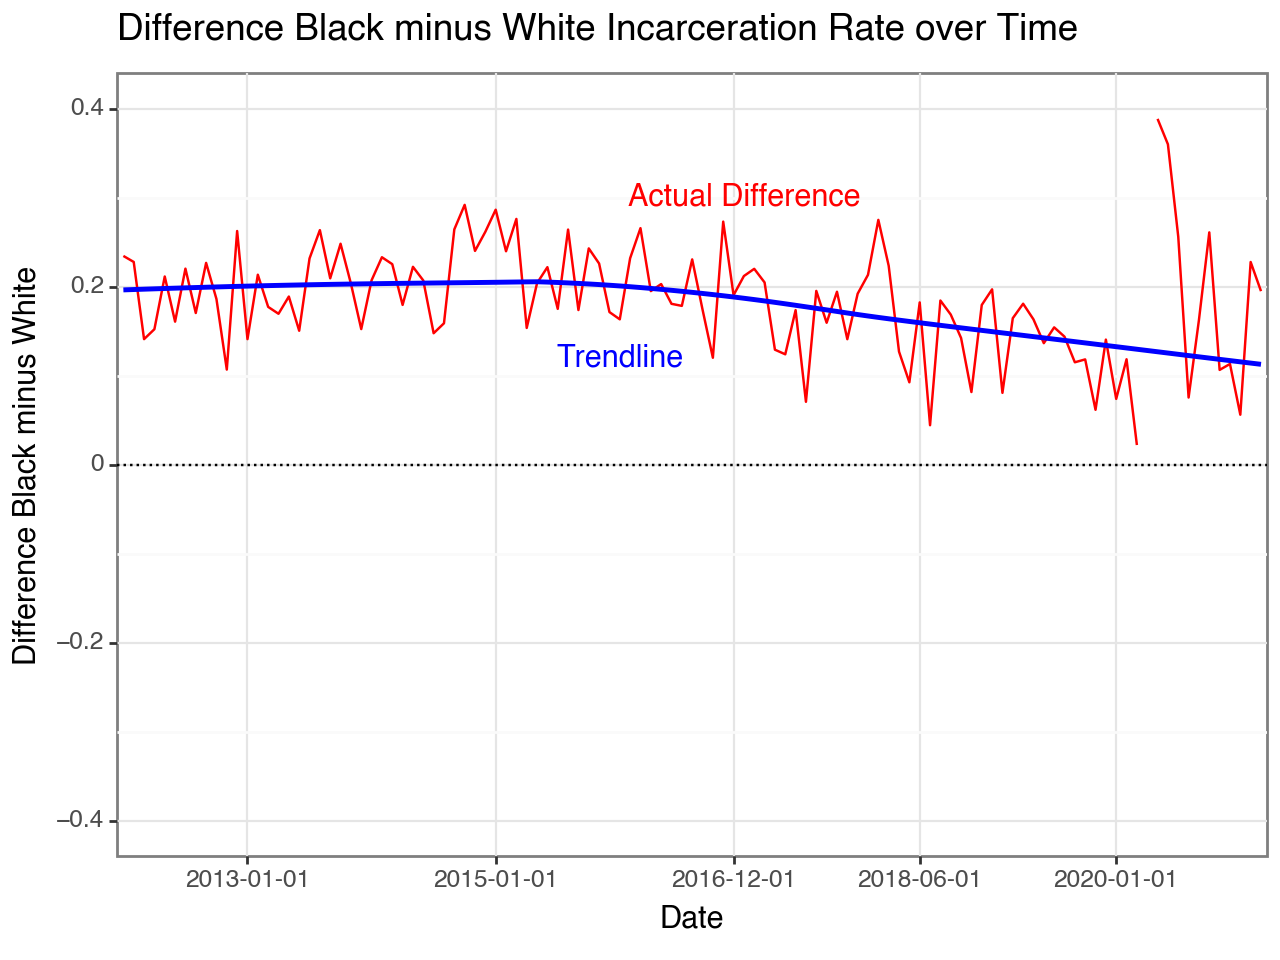

<Figure Size: (640 x 480)>

In [16]:
#filter
incarcerated = C[C["COMMITMENT_TYPE"] == "Illinois Department of Corrections"]

#calculations
black_inc_month = incarcerated[incarcerated["is_black_derived"]].groupby("sentenceym_derived")["CASE_ID"].agg("count")
white_inc_month = incarcerated[incarcerated["is_white_derived"]].groupby("sentenceym_derived")["CASE_ID"].agg("count")

frac_black_inc = black_inc_month / black_def_month
frac_white_inc = white_inc_month / white_def_month

#merge
bw_inc = pd.merge(frac_black_inc, frac_white_inc, on = "sentenceym_derived").reset_index()
bw_inc = bw_inc.rename(columns = {"CASE_ID_x":"prop_black_inc", "CASE_ID_y":"prop_white_inc"})
bw_inc["bw_diff"] = bw_inc["prop_black_inc"] - bw_inc["prop_white_inc"]
bw_inc

#visualize
(ggplot(data = bw_inc) +
 geom_line(aes(x = "sentenceym_derived", y = "bw_diff"), group = 1, color = "red") +
 geom_smooth(aes(x = "sentenceym_derived", y = "bw_diff"), group = 1, color = "blue") +
 ggtitle("Difference Black minus White Incarceration Rate over Time") +
 labs(x = "Date", y = "Difference Black minus White") +
 scale_x_discrete(breaks = ("2013-01-01", "2015-01-01", "2016-12-01", "2018-06-01", "2020-01-01")) +
 scale_y_continuous(limits = (-0.4, 0.4)) +
 geom_hline(yintercept = 0, linetype = "dotted") +
 annotate(geom = "text", label = "Trendline", x = "2016-01-01", y = 0.12, color = "blue") +
 annotate(geom = "text", label = "Actual Difference", x = "2017-01-01", y = 0.3, color = "red") +
 theme_bw())
 

## 2.3: Investigating mechanisms: incaceration rates by charge

Your colleague sees the previous graph and is worried that the gap could be different---either wider or smaller---if you adjust for the fact that prosecutors have discretion in what crimes to charge defendants with. If white defendants are charged with crimes that tend to receive probation rather than incarceration, that could explain some of the gaps.

In the next questions, you'll begin to investigate this.

### 2.3.1: Find the most common offenses (3 points)

First, create a set of 'frequent offenses' that represent (over the entire period) the union of the 10 offenses Black defendant are most likely to be charged with and the 10 offenses white defendants are most likely to be charged with (might be far less than 20 total if there's a lot of overlap in common charges)

Use the `simplified_offense_derived` for this

In [17]:
# frequent offenses by race
fo_black = C[C["is_black_derived"]].groupby("simplified_offense_derived")["CASE_ID"].apply("count").reset_index().sort_values(by = "CASE_ID", ascending = False).head(10)
fo_white = C[C["is_white_derived"]].groupby("simplified_offense_derived")["CASE_ID"].apply("count").reset_index().sort_values(by = "CASE_ID", ascending = False).head(10)

#merging
fo_bw = pd.concat([fo_black, fo_white])
fo_bw = fo_bw["simplified_offense_derived"].unique()

### 2.3.2: Look at incarceration rates (again just whether incarcerated) by race and offense type for these top offenses (3 points)

Print a wide-format version of the resulting table (so each row is an offense type, one col is black incarceration rate for that offense type; another is the white incarceration rate) and interpret. Which offenses show the largest disparities in judges being less likely to sentence White defendants to incarceration/more likely to offer those defendants probation?


In [18]:
fo_list = fo_bw.tolist()

C["incarcerated_derived"] = C["COMMITMENT_TYPE"] == "Illinois Department of Corrections"
C["freq_offense_derived"] = C["simplified_offense_derived"].isin(fo_list)

pivot_table = pd.pivot_table(C[C["freq_offense_derived"]], values = "incarcerated_derived", 
                             index = "simplified_offense_derived", 
                             columns = ["is_black_derived", "is_white_derived"])
pivot_table.columns = ["Other Incarceration Rate", "White Incarceration Rate", "Black Incarceration Rate"]
pivot_table

,Other Incarceration Rate,White Incarceration Rate,Black Incarceration Rate
simplified_offense_derived,,,
Battery,0.368066,0.275552,0.509032
Burglary,0.467345,0.535763,0.661927
DUI,0.205762,0.341855,0.404997
Driving With Suspended Or Revoked License,0.404629,0.496552,0.582193
Narcotics,0.339537,0.242535,0.537876
Other Offense,0.219807,0.230228,0.340580
Residential Burglary,0.648766,0.654114,0.717791
Retail Theft,0.434286,0.449582,0.595713
Robbery,0.628235,0.589286,0.650341


The offenses showing the largest disparities in sentencing are battery, narcotics, and unlawful use of weapon. 

### 2.3.3: Examine whether this changes pre and post change to charging threshold for retail theft (13 points)

One important question is not only whether there are disparities by offense type but also whether these disparities are changing over time.

The SAO, for instance, announced in December of 2016 that they would no longer default to charging retail thefts of under \$1,000 as felonies. This change might have (1) decreased disparities or (2) increased disparities, depending on the correlation between race/ethnicity and magnitude of goods stolen: [news coverage](https://www.dnainfo.com/chicago/20161215/little-village/kim-foxx-raises-bar-for-retail-theft-felonies/). 

Focusing on `simplified_offense_derived` == "Retail theft." Using a function and/or loop (Dec. 2016 is always excluded as a transition month):

- Compare Black-White disparities before and after the change using a two-month bandwidth (so pre is October and November 2016; post is January and February 2017)

- Compare Black-White disparities before and after the change using a four-month bandwidth (so pre is August- November 2016; post is January - April 2017)

- Compare Black-White disparities using an eight-month bandwidth

- Compare Black-White disparities using a twelve-month bandwidth


------------------ 

- Print a table with the results (any organization is fine as long as it's clear)  

- Create a bar chart where the x axis represents different bandwidths (2, 4, etc); the y axis the size of the Black-White gap in whether the defendant receives incarceration, and for each of the x axis points, you have one shaded bar representing "before" the change, another representing "after" the change (make sure that before is ordered before after and the bandwidths are from smallest to largest)

*Note*: for each of the bandwidths include dates the entire month (e.g., for the first, include not only 02-01-2017 but everything up through 02-28-2017; easiest way is for the subsetting to use the rounded `sentenceym_derived`). Also make sure to only include white or black defendants.


**Extra credit**: because the bandwidths have different sample sizes, a better viz incorporates measures of uncertainty. Add standard errors to the estimates using the formula: $(\dfrac{p(1-p)}{n})^{0.5}$ where $p$ is the gap and $N$ is the number of cases in each bandwidth period 


In [19]:
# subset the dataframe to only include cases of retail theft
rc = rule_change = C[C["simplified_offense_derived"] == "Retail Theft"]

# create a function that compares disparities in incarceration rates over a period of time
def retail_theft_disparity(pre_start, post_end):
    # format dates
    pre_start_date = pre_start
    pre_end_date = "2016-11-30"
    post_start_date = "2017-01-01"
    post_end_date = post_end
   
    # subset dataframes by date ranges
    pre = rc[(rc["sentenceym_derived"] >= pre_start_date) & (rc["sentenceym_derived"] <= pre_end_date)]
    post = rc[(rc["sentenceym_derived"] >= post_start_date) & (rc["sentenceym_derived"] <= post_end_date)]
   
    # group by race and calculate incarceration rates
    pre_disp = pre.groupby(["is_black_derived", "is_white_derived"])["incarcerated_derived"].agg("mean")
    post_disp = post.groupby(["is_black_derived", "is_white_derived"])["incarcerated_derived"].agg("mean")
    
#     print("Pre-Announcement\nWhite Incarceration Rate: %f\nBlack Incarceration Rate: %f\nDifference: %f\n" %(pre_disp[False][True], pre_disp[True][False], pre_disp[True][False] - pre_disp[False][True]))
#     print("Post-Announcement\nWhite Incarceration Rate: %f\nBlack Incarceration Rate: %f\nDifference: %f" %(post_disp[False][True], post_disp[True][False], post_disp[True][False] - post_disp[False][True]))
#     print("\n\n")
    
    return ((pre_disp[True][False] - pre_disp[False][True]), (post_disp[True][False] - post_disp[False][True]))

,Bandwidth (Months),Policy Change,disp
0,2,Before,0.087912
1,4,Before,0.081588
2,8,Before,0.132900
3,12,Before,0.161618
4,2,Post,0.154949
5,4,Post,0.081615
6,8,Post,0.043450
7,12,Post,0.064705


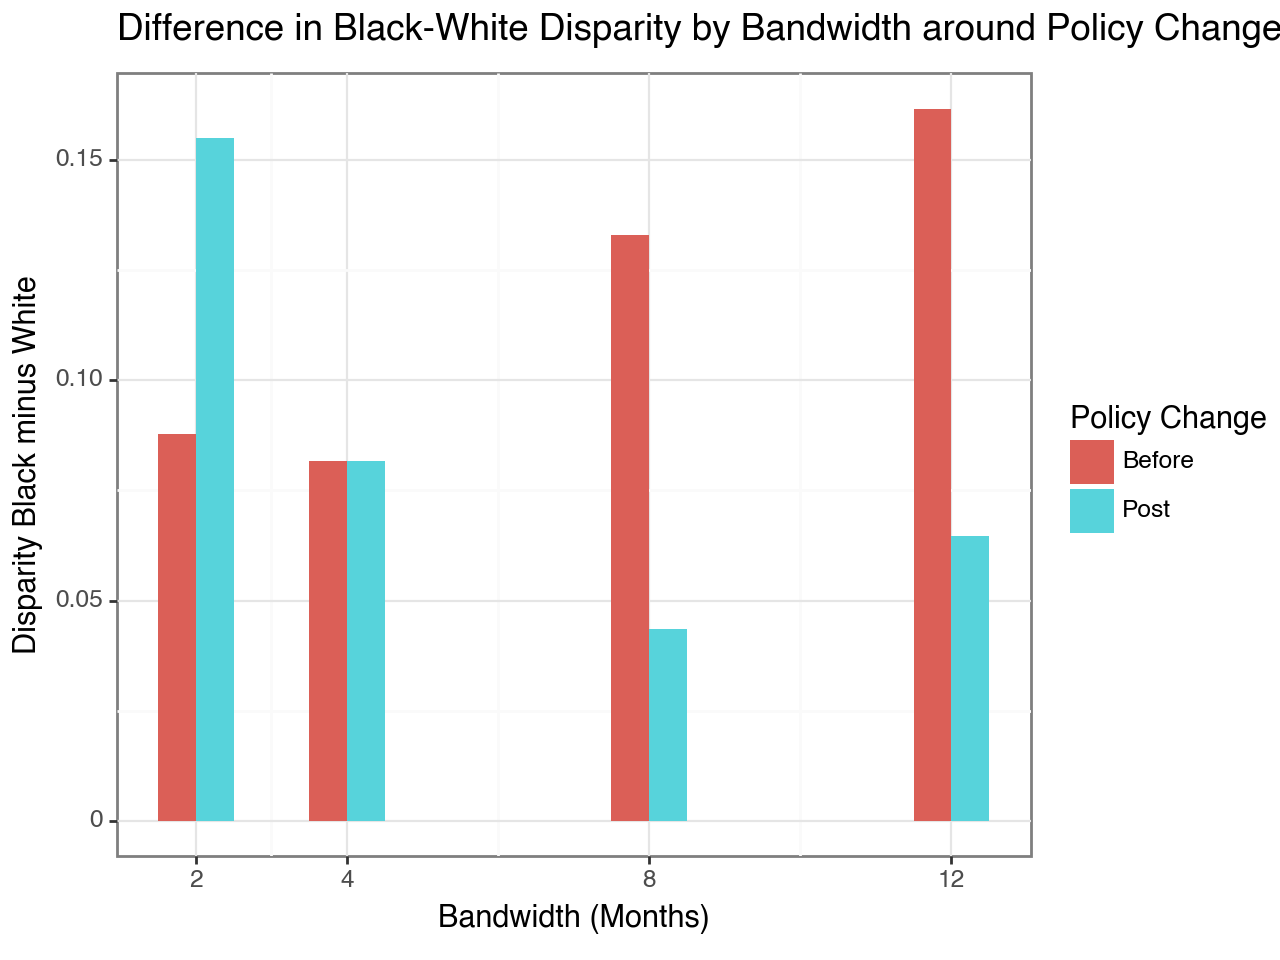

<Figure Size: (640 x 480)>

In [20]:
pre_list = []
post_list = []

pre_list.append(retail_theft_disparity("2016-10-01", "2017-02-28")[0])
post_list.append(retail_theft_disparity("2016-10-01", "2017-02-28")[1])

pre_list.append(retail_theft_disparity("2016-08-01", "2017-04-30")[0])
post_list.append(retail_theft_disparity("2016-08-01", "2017-04-30")[1])

pre_list.append(retail_theft_disparity("2016-04-01", "2017-08-31")[0])
post_list.append(retail_theft_disparity("2016-04-01", "2017-08-31")[1])

pre_list.append(retail_theft_disparity("2015-12-01", "2017-12-31")[0])
post_list.append(retail_theft_disparity("2015-12-01", "2017-12-31")[1])

data = {"disp_Before":pre_list, "disp_Post":post_list, "Bandwidth (Months)": [2, 4, 8, 12]}

retail_theft_disp = pd.DataFrame(data)
retail_theft_disp = pd.wide_to_long(retail_theft_disp, stubnames = "disp", i = "Bandwidth (Months)", j = "Policy Change", sep='_', suffix=r'\w+').reset_index()
retail_theft_disp

#visualize

(ggplot(retail_theft_disp, aes(x = "Bandwidth (Months)", y= "disp", fill = "Policy Change")) +
 geom_bar(stat="identity", width=1, position = "dodge") +
 labs(y = "Disparity Black minus White",
     title = "Difference in Black-White Disparity by Bandwidth around Policy Change") +
 scale_x_continuous(breaks = (2, 4, 8, 12)) +
 theme_bw())

### 2.3.3.1: Interpret the results (2 points)

Write a two-sentence interpretation of the results. What might this show about how people on both sides of the issue---those who argued that the retail theft policy change would narrow disparities; those who argued that the change may widen disparities--could support their claims? 

The results show that disparities increased immediately following the change, but over time they lowered. When using a 12-month bandwidth, it is clear that the change had a positive effect, decreasing the incarceration disparities for retail theft. Both sides of the argument could use this data. Those who argued that the change may widen disparities could point to the two-month bandwidth and argue that the decrease in disparities that we see in the long run was clearly not due to the policy change.